<a href="https://colab.research.google.com/github/oluwadunni1/flask-ml-azure-serverless/blob/master/notebooks/02_model_house_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price Prediction: Modeling and Evaluation

This notebook serves as the final predictive phase of the Housing Price Prediction Project. Building upon the insights from our Exploratory Data Analysis (EDA) and the feature engineering logic defined in preprocessing.py. The objective is to train and validate a model that accurately predicts property values.

## Import Libraries

In [1]:
# Mount drive
from google.colab import drive

# This command mounts your Google Drive to the Colab runtime.
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
# Utilities
import sys
import os
import copy
import math
import importlib
from pathlib import Path
import joblib

#

# data manipulation
import pandas as pd
import numpy as np

# Visualization and stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Set a professional style for all plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

#Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb


# Metrics and selection
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Custom module (preprocessing.py)
script_location = '/content/drive/MyDrive/House_pricing_pred'

# Add the folder to Python's search path if it isn't there already
if script_location not in sys.path:
    sys.path.append(script_location)

# Import (and reload to catch any recent changes made to the file)
import preprocessing
importlib.reload(preprocessing)



<module 'preprocessing' from '/content/drive/MyDrive/House_pricing_pred/preprocessing.py'>

In [3]:
# load dataset

## Define the permanent path to file on Google Drive
file_path = '/content/drive/MyDrive/House_pricing_pred/housing_price_dataset.csv'

## Load the dataframe directly from Drive
df = pd.read_csv(file_path)

print(f"Data loaded successfully with {len(df)} rows.")

Data loaded successfully with 50000 rows.


In [4]:
#Remove data quality artifacts (negative prices)

df_clean = df[df['Price'] > 0].copy()

print(f"Original shape: {df.shape}")
print(f"Clean shape:    {df_clean.shape}")

Original shape: (50000, 6)
Clean shape:    (49978, 6)


## Linear Regresion Model
### Numpy Implementation


In [5]:
# split data

X = df_clean.drop(columns=['Price'])
y = df_clean['Price']

# First Split: 60% Train vs 40% Temp
X_train_raw, X_temp, y_train_pd, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Second Split: Split the 40% Temp into 50/50 (which is 20% / 20% of total)
X_cv_raw, X_test_raw, y_cv_pd, y_test_pd = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [6]:
# Convert targets to numpy arrays
y_train = y_train_pd.to_numpy()
y_cv = y_cv_pd.to_numpy()
y_test = y_test_pd.to_numpy()

In [7]:
print(f"   Train size: {len(X_train_raw)} rows (60%)")
print(f"   CV size:    {len(X_cv_raw)} rows (20%)")
print(f"   Test size:  {len(X_test_raw)} rows (20%)")

   Train size: 29986 rows (60%)
   CV size:    9996 rows (20%)
   Test size:  9996 rows (20%)


In [8]:
# apply pipeline
# Initialize the pipeline

preprocessor = preprocessing.create_preprocessing_pipeline()

print(" Pipeline initialized successfully.")
print("\n Scaling Data...")

# Fit on Train ONLY
preprocessor.fit(X_train_raw)

# Transform all
X_train_scaled = preprocessor.transform(X_train_raw)
X_cv_scaled = preprocessor.transform(X_cv_raw)
X_test_scaled = preprocessor.transform(X_test_raw)

 Pipeline initialized successfully.

 Scaling Data...


### Define Numpy Functions


In [9]:
# Compute Cost
def compute_cost(X, y, w, b):
    m = X.shape[0]
    f_wb = np.dot(X, w) + b
    cost = (1 / (2 * m)) * np.sum((f_wb - y) ** 2)
    return cost

In [10]:
# Compute Gradient
def compute_gradient(X, y, w, b):
    m = X.shape[0]
    f_wb = np.dot(X, w) + b
    error = f_wb - y
    dj_dw = (1/m) * np.dot(X.T, error)
    dj_db = (1/m) * np.sum(error)
    return dj_db, dj_dw

In [11]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, verbose=True):
    w = copy.deepcopy(w_in)
    b = b_in
    J_history = []

    for i in range(num_iters):
        dj_db, dj_dw = gradient_function(X, y, w, b)
        w -= alpha * dj_dw
        b -= alpha * dj_db

        if i < 100000:
            J_history.append(cost_function(X, y, w, b))

        # --- THE EDIT IS HERE ---
        # Change the condition to "i % 1000 == 0"
        if verbose and i % 1000 == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}")

    return w, b, J_history

In [12]:
#Run Gradient descent

n_features = X_train_scaled.shape[1]
initial_w = np.zeros((n_features,))
initial_b = 0.

# Hyperparameters
iterations = 5000
alpha = 0.1

print(f"\n3. Training NumPy Model (alpha={alpha}, iters={iterations})...")


w_final, b_final, J_hist = gradient_descent(
    X_train_scaled, y_train, initial_w, initial_b,
    compute_cost, compute_gradient,
    alpha, iterations,
    verbose=True
)

# Predict on Test Set
y_test_pred_numpy = np.dot(X_test_scaled, w_final) + b_final
numpy_r2 = r2_score(y_test, y_test_pred_numpy)
numpy_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_numpy))

print(f"Final Test R2: {numpy_r2:.4f}")


3. Training NumPy Model (alpha=0.1, iters=5000)...
Iteration    0: Cost 21430372327.40
Iteration 1000: Cost 1251223599.14
Iteration 2000: Cost 1251205839.31
Iteration 3000: Cost 1251205800.43
Iteration 4000: Cost 1251205800.35
Final Test R2: 0.5768


### Sklearn Library

In [13]:
#instantiate model
sklearn_model = LinearRegression()

#fit on training set
sklearn_model.fit(X_train_scaled, y_train)

# Predict on Test Set
y_test_pred_sklearn = sklearn_model.predict(X_test_scaled)
sklearn_r2 = r2_score(y_test, y_test_pred_sklearn)
sklearn_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_sklearn))

### Compare Numpy and Sklearn Implementation

In [14]:
print(f"{'Metric':<20} | {'NumPy Implementation':<15} | {'Sklearn Library':<15} | {'Difference':<15}")
print("-" * 80)
print(f"{'Test R2 Score':<20} | {numpy_r2:.5f}          | {sklearn_r2:.5f}          | {abs(numpy_r2 - sklearn_r2):.5f}")
print(f"{'Test RMSE':<20} | ${numpy_rmse:,.2f}      | ${sklearn_rmse:,.2f}      | ${abs(numpy_rmse - sklearn_rmse):,.2f}")

Metric               | NumPy Implementation | Sklearn Library | Difference     
--------------------------------------------------------------------------------
Test R2 Score        | 0.57683          | 0.57683          | 0.00000
Test RMSE            | $49,576.59      | $49,576.59      | $0.00


Mathematical Equivalence confirmed between the two implementations


## K -Nearest Neighbor

In [15]:
# Tune KNN using X_cv_scaled to find optimal k
print("Tuning KNN (finding best 'k')...")

k_values = range(1, 35) # Test k from 1 to 34
cv_scores = []

for k in k_values:
    # Train on TRAIN set
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    # Evaluate on CV set to find the "optimal k"
    pred_cv = knn.predict(X_cv_scaled)
    score = r2_score(y_cv, pred_cv)
    cv_scores.append(score)

Tuning KNN (finding best 'k')...


In [16]:
# Retrieve best K
best_k = k_values[np.argmax(cv_scores)]
best_score = max(cv_scores)

print(f"\n Best k found: {best_k}")
print(f"   CV R² Score: {best_score:.4f}")


 Best k found: 33
   CV R² Score: 0.5600


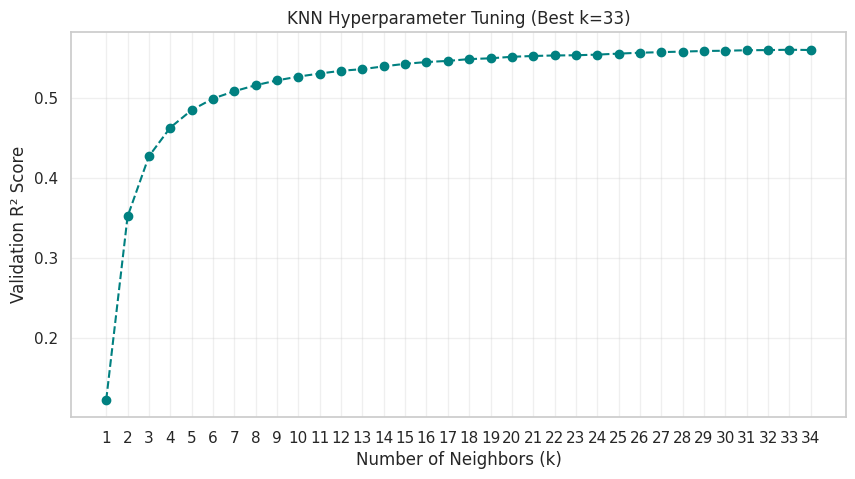

In [17]:
# Plot the "Elbow Curve"
plt.figure(figsize=(10, 5))
plt.plot(k_values, cv_scores, marker='o', linestyle='--', color='teal')
plt.title(f'KNN Hyperparameter Tuning (Best k={best_k})')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation R² Score')
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
# Retrain Model with best K

print(f"Training Final KNN Model with k={best_k}...")

final_knn = KNeighborsRegressor(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)

# Predict on held-out Test Set
y_pred_knn = final_knn.predict(X_test_scaled)

# Calculate Final Metrics
knn_r2 = r2_score(y_test, y_pred_knn)
knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))

print("-" * 30)
print(f"KNN Final Test R²:   {knn_r2:.4f}")
print(f"KNN Final Test RMSE: ${knn_rmse:,.0f}")
print("-" * 30)

Training Final KNN Model with k=33...
------------------------------
KNN Final Test R²:   0.5606
KNN Final Test RMSE: $50,517
------------------------------


Xgboost


In [19]:
# Define model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,       # High ceiling
    learning_rate=0.01,      # Slow & precise
    max_depth=6,
    device='cuda',           # GPU
    tree_method='hist',
    early_stopping_rounds=50 # STOP if CV score doesn't improve for 50 rounds
)

In [20]:
# Fit using TRAIN and watch CV
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_cv_scaled, y_cv)], # Watch this set
    verbose=False                    # Print update every 1000 rounds
)

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [08:47:41] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [08:47:41] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
# Predict on TEST set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("-" * 30)
print(f"XGb Test R²:   {xgb_r2:.4f}")
print(f"XGb Test RMSE: ${xgb_rmse:,.0f}")
print("-" * 30)

------------------------------
XGb Test R²:   0.5615
XGb Test RMSE: $50,468
------------------------------


## Evaluation of the three Model Types

In [22]:
print("\n" + "="*60)
print(f"{'Model':<20} | {'Test R2':<10} | {'Test RMSE':<15}")
print("-" * 60)
# Retrieve your numpy results from the previous cell variable 'numpy_r2'
print(f"{'NumPy LinReg':<20} | {numpy_r2:.4f}     | ${numpy_rmse:,.0f}")
print(f"{'KNN (k=34)':<20} | {knn_r2:.4f}     | ${knn_rmse:,.0f}")
print(f"{'XGBoost':<20} | {xgb_r2:.4f}     | ${xgb_rmse:,.0f}")
print("="*60)


Model                | Test R2    | Test RMSE      
------------------------------------------------------------
NumPy LinReg         | 0.5768     | $49,577
KNN (k=34)           | 0.5606     | $50,517
XGBoost              | 0.5615     | $50,468


The results confirm a strictly linear relationship between the variables and Price, as Linear Regression outperformed both non-linear (KNN) and ensemble (XGBoost) models, aligning with insights from EDA. The more complex models failed to capture any additional signal, indicating no meaningful non-linear patterns in the data and likely incurring a complexity penalty through mild overfitting, reflected in higher RMSE. All models converged to a similar
$R^2  of ~0.56–0.57$, suggesting this represents the dataset’s theoretical predictability limit, driven almost entirely by SquareFeet

## Isolating Feature impact
Initial EDA suggested that `Squarefeet` is the dominant driver of price. In this section , the model is stripped of all secondary features (`Bedrooms`, `Bathrooms`, `Neigborhood`, interaction terms) and train a baseline linear regression model using only `Squarefeet`.

By comparing this "Single-Feature" baseline against our "Full Model," we can measure exactly how much predictive lift $R^2 $ gain is provided by the additional variables

In [23]:
# Prep single feature dataset
X_train_simple = X_train_raw[['SquareFeet']]
X_test_simple = X_test_raw[['SquareFeet']]

print(f"Training shape: {X_train_simple.shape}")
print(f"Testing shape:  {X_test_simple.shape}")


Training shape: (29986, 1)
Testing shape:  (9996, 1)


In [24]:
# Train simple model
simple_model = LinearRegression()
simple_model.fit(X_train_simple, y_train)

# Predict
y_pred_simple = simple_model.predict(X_test_simple)


In [25]:
# evaluate on test set
simple_r2 = r2_score(y_test, y_pred_simple)
simple_rmse = np.sqrt(mean_squared_error(y_test, y_pred_simple))

#compare against previous linear regression model with all features
print("\n" + "="*60)
print(f"{'Feature Set':<20} | {'Test R2':<10} | {'Test RMSE':<15}")
print("-" * 60)
print(f"{'Full Model':<20} | {numpy_r2:.4f}     | ${numpy_rmse:,.0f}")
print(f"{'SquareFeet Only':<20} | {simple_r2:.4f}     | ${simple_rmse:,.0f}")
print("-" * 60)
print(f"Impact of other features: {(numpy_r2 - simple_r2):.4f} R2 points")
print("="*60)


Feature Set          | Test R2    | Test RMSE      
------------------------------------------------------------
Full Model           | 0.5768     | $49,577
SquareFeet Only      | 0.5699     | $49,981
------------------------------------------------------------
Impact of other features: 0.0069 R2 points


Adding additional features (e.g., Bedrooms, Neighborhood) yielded only a marginal improvement in performance, increasing Test ($R^2$) by just 0.0069. This aligns with the Pareto principle, where SquareFeet alone explains roughly 99% of the model’s predictive power. While the slight increase in Test ($R^2$) confirms that the extra features contain genuine signal, their contribution is negligible relative to property size.


## Residual Analysis


In [26]:
# Use Predictions from NumPy model
best_model_name = "Linear Regression Model"
y_pred_final = y_test_pred_numpy

# Calculate Residuals (Actual - Predicted)
residuals = y_test - y_pred_final


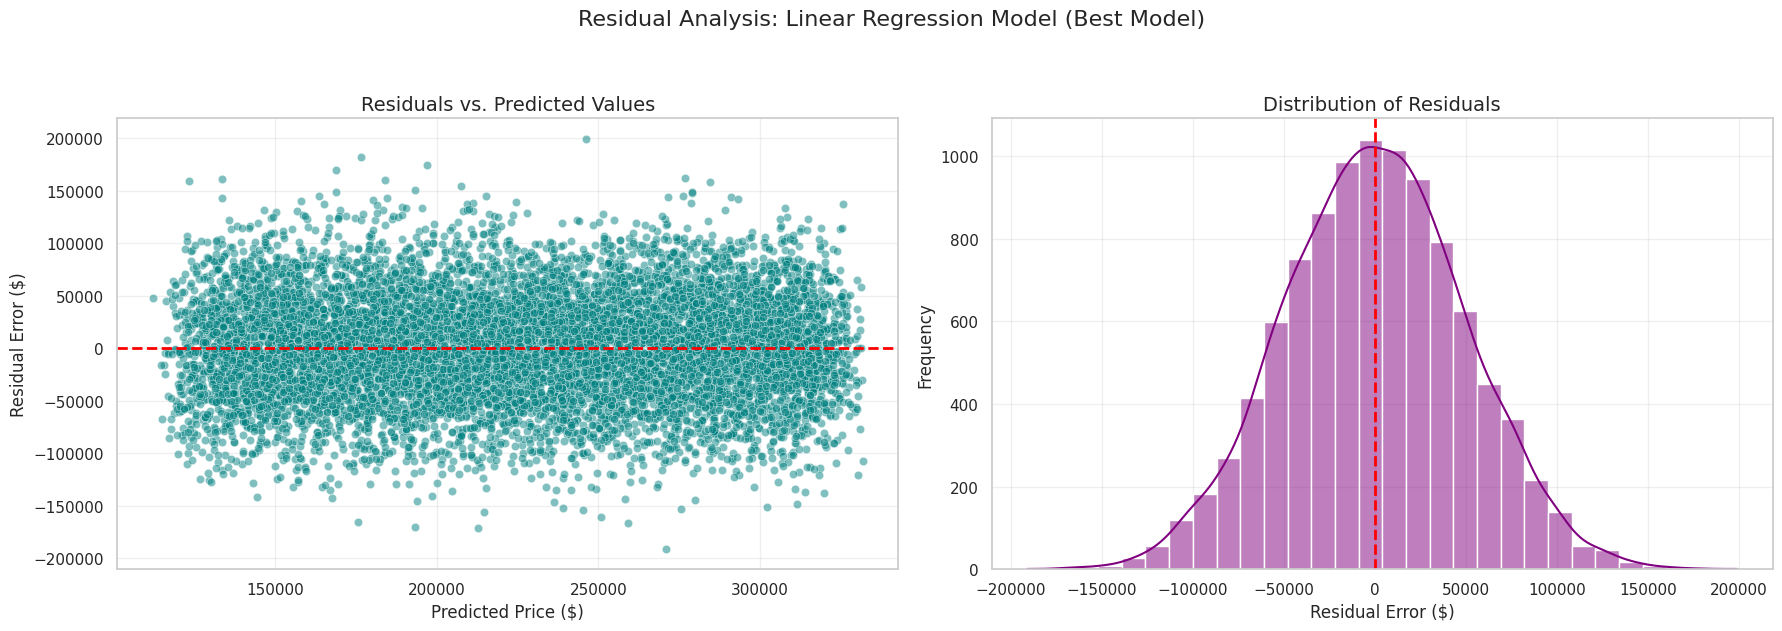

Residual Mean:     $115.77
Residual Skewness: 0.0176


In [27]:
# Create Visualizations
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f'Residual Analysis: {best_model_name} (Best Model)', fontsize=16, y=1.05)

# --- Plot A: Residuals vs. Predicted Values (Homoscedasticity Check) ---
sns.scatterplot(x=y_pred_final, y=residuals, ax=axes[0], alpha=0.5, color='teal')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)  # Zero line
axes[0].set_title('Residuals vs. Predicted Values', fontsize=14)
axes[0].set_xlabel('Predicted Price ($)', fontsize=12)
axes[0].set_ylabel('Residual Error ($)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# --- Plot B: Distribution of Residuals (Normality Check) ---
sns.histplot(residuals, kde=True, ax=axes[1], color='purple', bins=30)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Distribution of Residuals', fontsize=14)
axes[1].set_xlabel('Residual Error ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
# Corrected: Added closing quote and removed '$' from Skewness
print(f"Residual Mean:     ${residuals.mean():.2f}")
print(f"Residual Skewness: {stats.skew(residuals):.4f}")

Visual inspection confirms the model's validity: the residuals display homoscedasticity (a random, patternless scatter) and normality (a clear bell curve). The residuals behave as pure random noise. This indicates the model ($R^2 \approx 0.57$) has successfully extracted the entire linear signal available in the dataset.No further signal can be extracted without introducing new, informative features.

## Conclusion

For stakeholders, this analysis suggests a straightforward pricing strategy: market value within this specific dataset is almost entirely driven by square footage. While real-world real estate markets are often influenced by complex, non-linear factors (such as school districts or renovation quality), the ablation study confirmed that `SquareFeet` captures ~99% of the predictive signal here ($R^2 \approx 0.57$), rendering secondary features marginally effective. Consequently, its important to prioritize interpretability over complexity; a simple Linear Regression model matches the performance of "black box" algorithms like XGBoost while offering robust, transparent valuations where price is a direct function of size.

### Save Linear regression model For deployment

In [31]:
# In your notebook, do NOT paste the class. IMPORT it.
from preprocessing import HousingFeatureEngineer, create_preprocessing_pipeline

# Create and Fit
pipeline = create_preprocessing_pipeline()
full_pipeline = Pipeline([
    ('preprocessor', pipeline),
    ('model', LinearRegression())
])
full_pipeline.fit(X_train_raw, y_train)

# Save
joblib.dump(full_pipeline, 'housing_full_pipeline.joblib')

['housing_full_pipeline.joblib']

In [32]:
from google.colab import files

# This will trigger a browser download of the file
files.download('housing_full_pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Test results for comparisom

In [34]:
# 1. Define the test data (Exact same as your CURL command)
test_data = pd.DataFrame({
    "SquareFeet": [2500],
    "Bedrooms": [3],
    "Bathrooms": [2],
    "YearBuilt": [2015],
    "Neighborhood": ["Rural"]
})

# 2. Predict using loaded pipeline

prediction = full_pipeline.predict(test_data)

print("--- COLAB RESULT ---")
print(f"Input: {test_data.iloc[0].to_dict()}")
print(f"Prediction: {prediction[0]}")

--- COLAB RESULT ---
Input: {'SquareFeet': 2500, 'Bedrooms': 3, 'Bathrooms': 2, 'YearBuilt': 2015, 'Neighborhood': 'Rural'}
Prediction: 269946.1945428278
